# Distributional Semantics Takes the SAT

*by Jason Stock for [CS542: Natural Language Processing](https://www.cs.colostate.edu/~cs542) at Colorado State University*

This notebook focuses on creating distributional semantic word vectors from a small vocabulary and comparing the Composes and Google distributional semantic word vectors.

In [1]:
import itertools
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

VOL = '/s/chopin/l/grad/stock/nvme/data/cs542/pa4'

# Create distributional semantic word vectors

In [2]:
with open(os.path.join(VOL, 'dist_sim_data.txt')) as f:
    test = [line.rstrip() for line in f]
test

['the men feed the dogs',
 'the women feed the dogs',
 'the women feed the men',
 'the men feed the men',
 'the dogs bite the men',
 'the dogs bite the women',
 'the dogs bite the dogs',
 'the dogs like the men',
 'the men like the women',
 'the women like the dogs',
 'the men like the dogs']

In [3]:
# count individual words
voc = list(set([item for sublist in [s.split() for s in test] for item in sublist]))
voc_dict = {voc[i]:i for i in range(len(voc))}
inv_voc_dict = {i:voc[i] for i in range(len(voc))}
voc_dict, inv_voc_dict

({'like': 0, 'women': 1, 'dogs': 2, 'the': 3, 'men': 4, 'bite': 5, 'feed': 6},
 {0: 'like', 1: 'women', 2: 'dogs', 3: 'the', 4: 'men', 5: 'bite', 6: 'feed'})

In [4]:
# compute cooccurrence matrix
C = np.zeros((len(voc),len(voc)))
for w in voc:
    for c in voc:
        if w != c:
            for sent in test:
                split = sent.split()
                if w in split and c in split:
                    bi = [(split[i], split[i+1]) for i in range(0, len(split)-1)]
                    C[voc_dict[w],voc_dict[c]] += bi.count((w, c))
                    C[voc_dict[w],voc_dict[c]] += bi.count((c, w))
voc, C

(['like', 'women', 'dogs', 'the', 'men', 'bite', 'feed'],
 array([[0., 1., 1., 4., 2., 0., 0.],
        [1., 0., 0., 5., 0., 0., 2.],
        [1., 0., 0., 9., 0., 3., 0.],
        [4., 5., 9., 0., 8., 3., 4.],
        [2., 0., 0., 8., 0., 0., 2.],
        [0., 0., 3., 3., 0., 0., 0.],
        [0., 2., 0., 4., 2., 0., 0.]]))

In [5]:
# inflate counts and smooth (you wouldn't need to inflate with appropriately-sized data)
C = C * 10 + 1
C

array([[ 1., 11., 11., 41., 21.,  1.,  1.],
       [11.,  1.,  1., 51.,  1.,  1., 21.],
       [11.,  1.,  1., 91.,  1., 31.,  1.],
       [41., 51., 91.,  1., 81., 31., 41.],
       [21.,  1.,  1., 81.,  1.,  1., 21.],
       [ 1.,  1., 31., 31.,  1.,  1.,  1.],
       [ 1., 21.,  1., 41., 21.,  1.,  1.]])

In [6]:
np.set_printoptions(5)
PPMI = np.zeros((len(voc),len(voc)))
t = np.sum(C)
for w in range(len(C)):
    for c in range(len(C)):
        PPMI[w,c] = max(np.log((C[w,c]/t) / ((np.sum(C[w])/t)*(np.sum(C[c])/t))), 0)
voc, PPMI

(['like', 'women', 'dogs', 'the', 'men', 'bite', 'feed'],
 array([[0.     , 0.30019, 0.     , 0.26169, 0.56854, 0.     , 0.     ],
        [0.30019, 0.     , 0.     , 0.47994, 0.     , 0.     , 0.94681],
        [0.     , 0.     , 0.     , 0.6049 , 0.     , 1.14342, 0.     ],
        [0.26169, 0.47994, 0.6049 , 0.     , 0.56429, 0.24332, 0.26169],
        [0.56854, 0.     , 0.     , 0.56429, 0.     , 0.     , 0.56854],
        [0.     , 0.     , 1.14342, 0.24332, 0.     , 0.     , 0.     ],
        [0.     , 0.94681, 0.     , 0.26169, 0.56854, 0.     , 0.     ]]))

In [7]:
# compare the word vector for “dogs” before and after PPMI reweighting
print(f"{'VOC':<4}", voc)
print(f"{'C':<4}", C[voc_dict['dogs']])
print(f"{'PPMI':<0}", PPMI[voc_dict['dogs']])

VOC  ['like', 'women', 'dogs', 'the', 'men', 'bite', 'feed']
C    [11.  1.  1. 91.  1. 31.  1.]
PPMI [0.      0.      0.      0.6049  0.      1.14342 0.     ]


**What happened to the elements of this vector that had a smoothed count of 1 in the smoothed count matrix?**
- Smoothed counts of one are set to zeros as a result of having a small joint probability and relatively higher independent probabilities.

**What happened to the elements of this vector that had the same value (not 1) in the smoothed count matrix?**
- Smoothed co-occurance values greater than one are typically set to non-zero values indicating how informative a context word is to the target word. However, the bigram "like the" has a joint probability that is less than the marginal probabilities, yielding ratio less than 1, and hence set to zero.

**Does it seem like PPMI reweighting did the right thing with regard to the representation of each context word c in the word vector for "dogs"? Why?**
- Yes, the context words "the" and "bite" have a low probability of occurring by themselves but their joint probabilities with "dogs" is high. This intuitively makes sense considering the small dataset as, for example, "dogs bite" is a more unique concept with the context word "bite" which does not occur with any other phrases. Furthermore, "dogs like" is not very unique and the context word "like" has little meaning with the word "dogs" as "men like" and "women like" are more indicative of the context for "like". All other context words (i.e. "men", "feed", and "women") do not occur as a bigram with "dogs" and while they may have a high individual probability $P(c)$ their joint probability $P(w,c)$ is very small. These values are set to zero and are explicitly captured in PPMI reweighting. 

In [8]:
examples = [('women', 'men'), ('women', 'dogs'), ('men', 'dogs'),
            ('feed', 'like'), ('feed', 'bite'), ('like', 'bite')]

for (ai, bi) in examples:
    a = PPMI[voc_dict[ai]]
    b = PPMI[voc_dict[bi]]
    print(f"{ai+' and '+bi:<14} -> {np.linalg.norm(a - b):.4f}")

women and men  -> 0.4714
women and dogs -> 1.5197
men and dogs   -> 1.3984
feed and like  -> 0.6466
feed and bite  -> 1.5898
like and bite  -> 1.3119


**Do the distances you compute above confirm our intuition from distributional semantics (i.e., similar words appear in similar contexts)?**
- Yes, the distances appear to make sense as words that are used in similar textual examples appear to have similar semantic meaning and smaller distances. For example, "women" and "men" are much closer than "women" and "dogs", and the use of "women" and "men" in the above sentences are similarly used. The opposite is true for words that have larger distances.

In [9]:
# decompose and reduce the PPMI matrix
U, E, Vt = np.linalg.svd(PPMI, full_matrices=False)
U = np.matrix(U) # compute U
E = np.matrix(np.diag(E)) # compute E
Vt = np.matrix(Vt) # compute Vt = conjugate transpose of V
V = Vt.T # compute V : conjugate transpose of Vt

reduced_PPMI = PPMI * V[:, 0:3]

In [10]:
for (ai, bi) in examples:
    a = reduced_PPMI[voc_dict[ai]]
    b = reduced_PPMI[voc_dict[bi]]
    print(f"{ai+' and '+bi:<14} -> {np.linalg.norm(a - b):.4f}")

women and men  -> 0.1277
women and dogs -> 1.0689
men and dogs   -> 0.9718
feed and like  -> 0.4440
feed and bite  -> 1.1329
like and bite  -> 0.9123


**Does the compact/reduced matrix still keep the information we need for each word vector?**
- Yes, the compact/reduced matrix has a similar scaled representation of the original PPMI matrix. That is, words used in similar context still have a smaller *relative* distance to those that do not and visa versa. Interestingly, it seems the retained information is directly related to the dimensionality of $V$. By reducing to two dimensions (i.e. `PPMI * V[:, 0:2]`), we find examples where the distance between "like and bite" is closer to zero (0.0819) than "women and men" (0.0961), which differs from the original PPMI matrix and shows not to keep the information. However, as shown above in three dimensions, the relative ordering of distances are preserved and thus the information of the original PPMI matrix.

# Computing with distributional semantic word vectors

In [11]:
with open(os.path.join(VOL,'SAT-package-V3.txt')) as f:
    data = []
    for c in f.read().split('\n\n')[1:]:
        prompt = c.split('\n')[1:]
        if len(prompt) > 7:
            prompt = prompt[:-1]
        prompt[-1] = ord(prompt[-1])-97
        data.append(prompt)
        
go = np.loadtxt(os.path.join(VOL, 'GoogleNews-vectors-rcv_vocab.txt'), dtype=str)
goV = {w:i for i, w in enumerate(go[:,0])}
go = go[:,1:].astype(np.float64)

en = np.loadtxt(os.path.join(VOL, 'EN-wform.w.2.ppmi.svd.500.rcv_vocab.txt'), dtype=str)
enV = {w:i for i, w in enumerate(en[:,0])}
en = en[:,1:].astype(np.float64)
go.shape, en.shape

((140921, 300), (65357, 500))

In [12]:
(go[goV['men']]-go[goV['human']]).reshape(-1,1).shape

(300, 1)

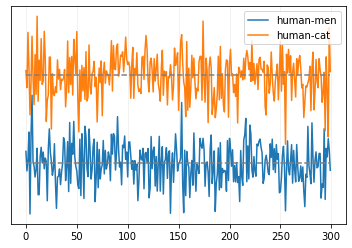

In [13]:
A = 'human'
B = 'men'
C = 'cat'
offset=0.8

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(go[goV[A]]-go[goV[B]], label=f'{A}-{B}')
ax.plot(go[goV[A]]-go[goV[C]]+offset, label=f'{A}-{C}')
ax.plot(np.ones((go.shape[1],2))*[0,offset],'--',color='gray')
ax.set_yticks([])
ax.grid(True, alpha=0.2)
ax.legend(loc=1);

In [31]:
def classifier(vector, voc, method='add', unknown='missing', seed=1234):
    if unknown == 'mean':
        unk = vector.mean(axis=0)
    elif unknown == 'noise':
        np.random.seed(seed)
        unk = np.random.uniform(np.min(vector), np.max(vector), vector.shape[1])
    elif unknown == 'missing' and method in ['add', 'sub', 'cat']:
        unk = np.zeros(vector.shape[1])
    elif unknown == 'missing' and method in ['mul', 'dot']:
        unk = np.ones(vector.shape[1])

    def getvec(k):
        try:
            return vector[voc[k]]
        except KeyError:
            return unk
        
    if method == 'add':
        compute = lambda a,b : getvec(a) + getvec(b)
    elif method == 'sub':
        compute = lambda a,b : getvec(a) - getvec(b)
    elif method == 'mul':
        compute = lambda a,b : getvec(a) * getvec(b)
    elif method == 'dot':
        compute = lambda a,b : getvec(a) @ getvec(b)
    elif method == 'cat':
        compute = lambda a,b : np.concatenate((getvec(a), getvec(b)))

    evaluate = lambda a,b : np.linalg.norm(a - b) # euclidian dist

    results = []
    for d in data:
        qlist = d[0].split()
        q = compute(qlist[0], qlist[1])
        
        metrics = []
        for li in d[1:-1]:
            plist = li.split()
            p = compute(plist[0], plist[1])
            metrics.append(evaluate(p,q))
            
        results.append(1 if d[-1] == np.argmin(metrics) else 0)

    return results, sum(results)/len(results)

In [35]:
goV

{'\x1b[?1034hLundazi': 0,
 'Eket': 1,
 'Asir': 2,
 'Simha': 3,
 'HRCP': 4,
 'Ngoako': 5,
 'Zaynab': 6,
 'Defendory': 7,
 'Pirkanmaa': 8,
 'Telgraph': 9,
 'Adamawa': 10,
 'Sharqiyah': 11,
 'Mbeya': 12,
 'tensive': 13,
 'Zambales': 14,
 'Oshun': 15,
 'Vaucluse': 16,
 'Photographer': 17,
 'Mtwara': 18,
 'Jaisalmer': 19,
 'Somatropin': 20,
 'Mandara': 21,
 'Duchesse': 22,
 'Kepak': 23,
 'Luapula': 24,
 'Gjirokastra': 25,
 'auberge': 26,
 'Tv': 27,
 'Hayride': 28,
 'Zephyr': 29,
 'Karuma': 30,
 'Hunedoara': 31,
 'Damaso': 32,
 'deeps': 33,
 'Bornholm': 34,
 'Depart': 35,
 'corridas': 36,
 'Monagas': 37,
 'Magics': 38,
 'NRK': 39,
 'Yachtsman': 40,
 'refectory': 41,
 'Brahmanbaria': 42,
 'Nasal': 43,
 'Zab': 44,
 'Somalian': 45,
 'Naranjos': 46,
 'Suwalki': 47,
 'Abendzeitung': 48,
 'Uige': 49,
 'Limousine': 50,
 'Camiguin': 51,
 'mukhabarat': 52,
 'Fribourg': 53,
 'Schonefeld': 54,
 'Moxico': 55,
 'Swimmer': 56,
 'Bumbuna': 57,
 'propagation': 58,
 'Bebek': 59,
 'Mukhabarat': 60,
 'madam': 

In [32]:
_, acc = classifier(go, goV, 'cat', 'missing')
acc

0.32620320855614976

In [15]:
methods  = ['add', 'sub', 'mul', 'dot', 'cat']
unknowns = ['missing', 'mean', 'noise']
vectors  = ['google', 'composes']

def which_vec(name):
    if name.lower() == 'google':
        return go, goV
    elif name.lower() == 'composes':
        return en, enV

results = []
for vec, method, unknown in itertools.product(vectors, methods, unknowns):
    _, accuracy = classifier(*which_vec(vec), method, unknown)
    results.append({'vec':vec, 'method':method, 'unknown':unknown, 'accuracy':accuracy})
df = pd.DataFrame(results)

In [16]:
df.loc[df['vec'] == 'google'].sort_values('accuracy', ascending=False)

,vec,method,unknown,accuracy
14,google,cat,noise,0.342246
4,google,sub,mean,0.339572
3,google,sub,missing,0.336898
5,google,sub,noise,0.331551
13,google,cat,mean,0.328877
12,google,cat,missing,0.326203
2,google,add,noise,0.280749
0,google,add,missing,0.272727
1,google,add,mean,0.270053
9,google,dot,missing,0.267380


In [17]:
df.loc[df['vec'] == 'composes'].sort_values('accuracy', ascending=False)

,vec,method,unknown,accuracy
27,composes,cat,missing,0.390374
28,composes,cat,mean,0.387701
29,composes,cat,noise,0.382353
20,composes,sub,noise,0.377005
18,composes,sub,missing,0.371658
19,composes,sub,mean,0.366310
16,composes,add,mean,0.318182
15,composes,add,missing,0.310160
17,composes,add,noise,0.299465
21,composes,mul,missing,0.259358


In [18]:
def count_unknowns(vector, voc):
    total = 0
    unknowns = set()
    for q in data:
        for d in q[:-1]:
            l = d.split()
            for i in range(2):
                try:
                    total += 1
                    _ = voc[l[i]]
                except KeyError:
                    unknowns.add(l[i])
    return unknowns, total
    
gounknowns, total = count_unknowns(*which_vec(vectors[0]))    
enunknowns, total = count_unknowns(*which_vec(vectors[1]))  

print('Proportion Unknown:')
print(f"   {'google':<8} {len(gounknowns)}/{total}")
print(f"   {'composes':<8} {len(enunknowns)}/{total}")

print('Dataset Unique Unknown Words:')
print(f"   {'google':<8} {gounknowns-enunknowns}")
print(f"   {'composes':<8} {enunknowns-gounknowns}")

Proportion Unknown:
   google   161/4488
   composes 159/4488
Dataset Unique Unknown Words:
   google   {'tranquillity', 'archaeology', 'catalogue', 'self-righteous'}
   composes {'propagandize', 'catnap'}


**Results**  

For each dataset we join the word vectors of the question and answer prompts in five different ways by adding, subtracting, multiplying, performing a dot product, and concatenating vectors. Unknown words, or those that are not in either of the word vectors, are dealt with by either setting the corresponding word vector to missing, the mean of the all vectors, or random noise sampled from a uniform distribution on the interval from [min, max] of the word vectors. "Missing" implies setting the unknown word vector to ones for multiplication and dot products and to a value of zero for all other methods. The same random seed is used for random noise across all questions. Evaluations are made by taking the answer prompt with the minimum euclidian distance to the question.

Interestingly, the composes data computed using classical distributional semantics (i.e. SVD reduced PPMI co-occurances) performs best with an accuracy of $\%39.04$ when concatenating words in a prompt and setting unknown words to missing. Using the Google data computed using deep learning, we only get at most a $\%34.22$ accuracy with concatenation and random noise for the unknown words. My initial assumptions for the difference in accuracy was related to the number of words in each of the datasets and the potential number of unknown words as the Google data has 140921 words and the composes dataset has 65357 words. However, it turns out that the SAT data has ~160 unique unknown words in both datasets. As shown directly above, the majority of the same words are unknown in both datasets with Google only having four unique unkown words that are actually present in composes. Therefore, I speculate that the ~$\%5$ difference in accuracy is not directly related to the unknown words but rather by something intrinsic to the model or dimensionality of the word vectors. Perhaps the underlying distribution of words used to create the word vectors is the driving differentiator between performance.

Concatenating vectors for every prompt shows the best performance over the other explored methods. By joining the word vectors we effectively increase the dimensionality which can be problematic with distance metrics (e.g. euclidian norm ) via the curse of dimensionality. However, it is possible that new information about the relationship of words are present in this high dimensional space that are not captured in the vector space when subtracting or multiply vectors. Furthermore, the composes word vectors are reduced to 500 dimension (versus 300 dimensions for Google), which for similar reasons, may also be the reason for better performance. Nevertheless, the composes word vectors performs better than the Google data using the same methods of vector similarity.

--